<a href="https://colab.research.google.com/github/da-vincee09/time_series_forecasting_with_LSTM/blob/main/time_series_forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting of Airline Passengers Using LSTM with TensorFlow/Keras**



In this notebook, we develop a **Long Short-Term Memory (LSTM)**–based time series forecasting model to predict monthly international airline passenger counts using the classic **AirPassengers** dataset. LSTMs are a specialized type of recurrent neural network capable of learning long-term dependencies, making them ideal for modeling time-based trends such as seasonality and growth patterns.

---

## **Background**

Accurate forecasting of airline passenger demand is essential for operational planning, revenue management, and strategic decision-making in the aviation industry. The **AirPassengers** dataset contains monthly totals of international airline passengers from **1949 to 1960**, exhibiting clear patterns of **trend** and **seasonality**, which makes it a widely used benchmark in time series modeling.

Traditional models like ARIMA have historically been applied to this dataset, but deep learning models—particularly LSTMs—have gained popularity due to their ability to:

* Capture complex nonlinear relationships
* Learn long-term temporal dependencies
* Model seasonality without explicit feature engineering

LSTMs avoid issues like vanishing gradients and are designed to handle sequential data, making them well suited for passenger demand forecasting.

---

## **Objectives**

This notebook presents a complete workflow for building, training, evaluating, and deploying an LSTM-based forecasting system. Specifically, we will:

### **1. Load and analyze the dataset**

* Import the monthly passenger dataset and parse timestamps
* Perform exploratory data analysis (EDA)
* Visualize trends and seasonality using line plots and rolling means

### **2. Preprocess and prepare sequences**

* Normalize values using MinMax scaling
* Create sliding-window sequences for supervised learning
* Split the data into training and testing sets while preserving temporal order

### **3. Build and train an LSTM model**

* Construct a sequential LSTM model with dropout and dense layers
* Train the model using early stopping and learning rate scheduling
* Save the best-performing model using modern `.keras` format

### **4. Evaluate forecasting performance**

* Generate predictions on the test set and inverse-transform values
* Compute metrics such as RMSE, MAE, and MAPE
* Plot actual vs. predicted passenger counts

### **5. Perform walk-forward forecasting**

* Use recursive prediction to simulate real-world forecasting
* Append each new prediction to the sequence history
* Visualize walk-forward results against actual data

### **6. Forecast future passenger demand**

* Perform multi-step forecasting (e.g., next 12 months)
* Plot predicted values on a future timeline
* Analyze long-term trend continuation and seasonality behavior

### **7. Save and reuse the model**

* Export the trained LSTM and scaler
* Provide a utility function to load the model and forecast new data automatically

---

> **By the end of this notebook**, you will have a fully functional LSTM-based time series forecasting system capable of predicting future airline passenger numbers, performing walk-forward evaluation, and generating multi-step forecasts suitable for real-world planning and decision-making.



In [1]:
# -------------------------------
# Install dependencies (only needed in Colab)
# -------------------------------
!pip install tensorflow matplotlib seaborn scikit-learn --quiet

# -------------------------------
# Core libraries
# -------------------------------
import os
import random
import numpy as np
import pandas as pd
import math

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Scikit-learn for metrics & preprocessing
# -------------------------------
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------
# TensorFlow / Keras
# -------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------------------
# Confirm imports
# -------------------------------
print("✅ All required libraries have been successfully imported.")

✅ All required libraries have been successfully imported.


# **Set Random Seed and Prepare Model Directory**


- **Purpose**: Ensure reproducibility of results across runs and set up a folder to save trained models.
- **Random Seed**:
  - `random.seed(seed)` for Python built-in random operations
  - `np.random.seed(seed)` for NumPy operations
  - `tf.random.set_seed(seed)` for TensorFlow/Keras operations
  - This ensures consistent weight initialization, shuffling, and other stochastic processes.
- **Model Directory**:
  - `MODEL_DIR` is set to `'./models'`.
  - `os.makedirs(MODEL_DIR, exist_ok=True)` creates the directory if it doesn’t exist, avoiding errors.
- **Why important?**
  1. **Reproducibility**: Critical for debugging, comparing models, and reporting results consistently.
  2. **Organization**: Keeps model files and checkpoints structured in a dedicated folder.
  3. **Compatibility with callbacks**: Required for saving the best model during training using ModelCheckpoint.

In [2]:
# -------------------------------
# Reproducibility and Model Directory Setup
# -------------------------------

# Function to set random seeds for reproducibility
# Ensures consistent results across Python, NumPy, and TensorFlow operations
def seed_everything(seed=42):
    random.seed(seed)      # Python built-in random module
    np.random.seed(seed)   # NumPy random operations
    tf.random.set_seed(seed)  # TensorFlow/Keras operations

# Call the function to set seeds
seed_everything(42)

# Define directory to save trained models
MODEL_DIR = './models'
# Create directory if it doesn't exist to avoid errors during saving
os.makedirs(MODEL_DIR, exist_ok=True)

# Confirm setup
print(f"✅ Reproducibility set with seed 42 and model directory '{MODEL_DIR}' ready.")

✅ Reproducibility set with seed 42 and model directory './models' ready.


# **Load Airline Passengers Dataset**


- **Purpose**: Load the historical monthly airline passenger dataset for time series forecasting.
- **Data Source**: CSV file hosted on GitHub.
  - `url`: Link to the CSV file containing the dataset.
- **Processing Steps**:
  - Read the CSV into a pandas DataFrame with `parse_dates=['Month']` to convert the 'Month' column to datetime objects.
  - Rename the 'Passengers' column to 'passengers' for consistency.
- **Verification**: Printing the first few rows confirms successful loading and correct column names.
- **Why this dataset?**
  1. **Classic benchmark**: Widely used for time series forecasting research and tutorials.
  2. **Trend and seasonality**: Exhibits clear monthly trends and yearly seasonality, ideal for LSTM modeling.
  3. **Compact size**: Small enough to run quickly in Colab, yet sufficient for deep learning experiments.

In [3]:
# ================================================================
# LOAD DATASET
# ================================================================

# URL of the AirPassengers dataset (monthly totals of international airline passengers from 1949 to 1960)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# Read the CSV file into a pandas DataFrame
# parse_dates=['Month'] converts the 'Month' column to datetime objects for easier time series handling
df = pd.read_csv(url, parse_dates=['Month'])

# Rename the 'Passengers' column to 'passengers' for consistency and easier referencing
df.rename(columns={'Passengers': 'passengers'}, inplace=True)

# Display the first 5 rows of the dataset to verify successful loading and correct column names
print(df.head())

# Purpose:
# - Load the historical airline passenger dataset for time series forecasting
# - Ensure 'Month' is datetime for plotting, indexing, and sequence generation
# - Confirm data integrity and column naming

       Month  passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121


# **Exploratory Data Analysis (EDA)**


- **Purpose**: Gain insights into the dataset and understand the underlying trends, seasonality, and distribution of airline passengers.
- **Analysis Steps**:
  - Use `df.info()` to check column types, non-null counts, and general structure.
  - Use `df.describe()` to summarize statistics like mean, std, min, max, and quartiles.
  - Plot the monthly passenger counts to visualize trends over time.
  - Create a rolling mean (12 months) plot to highlight the long-term trend and smooth out short-term fluctuations.
- **Verification**: Plots and summary statistics confirm correct data types, completeness, and expected trends.
- **Why this step is important?**
  1. **Understand data distribution**: Helps in preprocessing and modeling decisions.
  2. **Identify trends & seasonality**: Critical for time series modeling, especially for LSTM networks.
  3. **Detect anomalies**: Visualization helps spot outliers or irregular patterns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None
                     Month  passengers
count                  144  144.000000
mean   1954-12-16 05:00:00  280.298611
min    1949-01-01 00:00:00  104.000000
25%    1951-12-24 06:00:00  180.000000
50%    1954-12-16 12:00:00  265.500000
75%    1957-12-08 18:00:00  360.500000
max    1960-12-01 00:00:00  622.000000
std                    NaN  119.966317


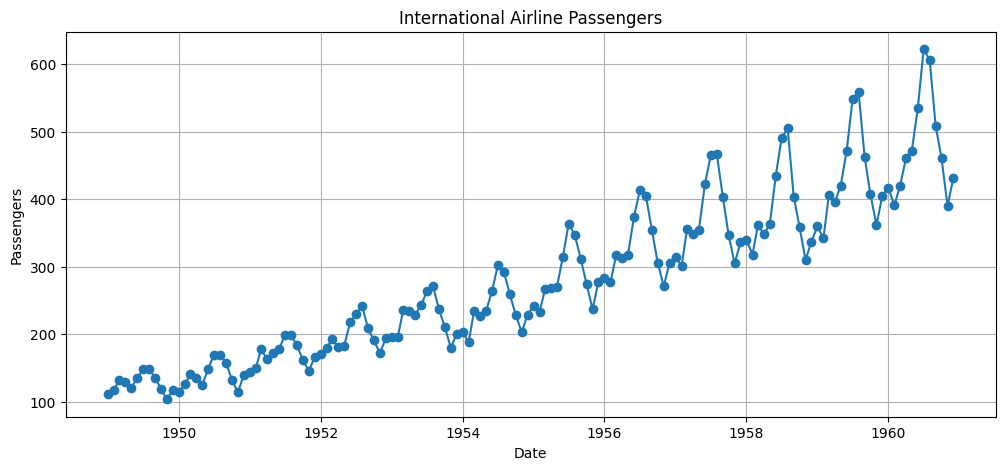

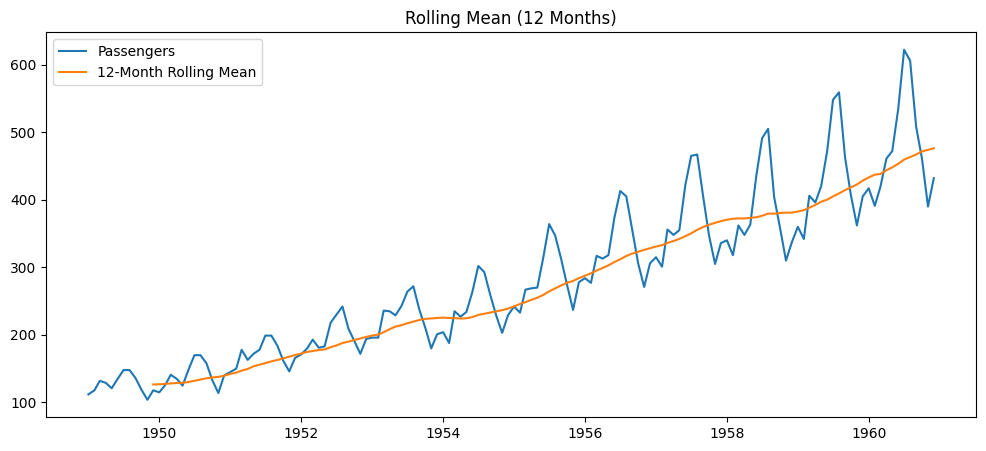

In [4]:
# ================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ================================================================

# Display general information about the dataset
# Includes column types, non-null counts, and memory usage
print(df.info())

# Summary statistics of the 'passengers' column
# Provides count, mean, std, min, max, and quartiles
print(df.describe())

# Plot the time series of monthly airline passengers
plt.figure(figsize=(12,5))
plt.plot(df['Month'], df['passengers'], marker='o')
plt.title('International Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

# Set 'Month' as the index for time series analysis
ts = df.set_index('Month')

# Plot the series with a 12-month rolling mean to observe trend and seasonality
plt.figure(figsize=(12,5))
plt.plot(ts['passengers'], label='Passengers')
plt.plot(ts['passengers'].rolling(12).mean(), label='12-Month Rolling Mean')
plt.title('Rolling Mean (12 Months)')
plt.legend()
plt.show()

# **Data Preprocessing**


- **Purpose**: Prepare the airline passenger dataset for LSTM modeling by scaling values and creating sequences.
- **Steps**:
  1. **Reshape and type conversion**:
      - Convert passenger counts to `float32` and reshape to (-1, 1) for scaler compatibility.
  2. **Scaling**:
      - Apply `MinMaxScaler` to normalize values between 0 and 1, which improves LSTM training stability.
  3. **Sequence creation**:
      - Use a sliding window approach to create sequences of length `SEQ_LEN`.
      - Each sequence `X` contains `SEQ_LEN` past observations, and the corresponding `y` is the next value.
- **Sequence Length**: 12 months (captures yearly seasonality).
- **Verification**: Print shapes of `X` and `y` to confirm correct sequence generation.

In [5]:
# ================================================================
# PREPROCESSING
# ================================================================

# Extract passenger values and reshape for scaler compatibility
# Convert to float32 to ensure consistent data type for TensorFlow
values = ts['passengers'].values.reshape(-1,1).astype('float32')

# Apply MinMaxScaler to normalize data between 0 and 1
# Normalization helps LSTM models converge faster and prevents gradient issues
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# Function to create input sequences (X) and corresponding targets (y)
# Uses a sliding window approach over the time series
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])  # Sequence of length seq_len
        y.append(data[i+seq_len])    # Next value to predict
    return np.array(X), np.array(y)

# Define sequence length (e.g., 12 months to capture yearly seasonality)
SEQ_LEN = 12

# Generate sequences and targets for LSTM input
X, y = create_sequences(scaled, SEQ_LEN)

# Print shapes to verify correct sequence creation
print('X:', X.shape, 'y:', y.shape)

X: (132, 12, 1) y: (132, 1)


# **Train/Test Split**


- **Purpose**: Split the sequences and targets into training and testing sets while preserving temporal order.
- **Steps**:
  1. **Define training size**:
      - Use 80% of the sequences for training.
  2. **Split data**:
      - `X_train` and `y_train` for model training.
      - `X_test` and `y_test` for model evaluation.
  3. **Preserve time order**:
      - Important for time series forecasting to avoid data leakage.
- **Verification**: Print shapes of the train and test sets to confirm correct splitting.
- **Why important?**
  1. Ensures the model is trained on past data and evaluated on future unseen data.
  2. Maintains sequence continuity required for LSTM temporal learning.

In [6]:
# ================================================================
# TRAIN/TEST SPLIT
# ================================================================

# Define training set size as 80% of the total sequences
train_size = int(len(X) * 0.8)

# Split input sequences and targets into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes to verify correct splitting
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (105, 12, 1) Test: (27, 12, 1)


# **Build LSTM Model**


- **Purpose**: Construct and compile an LSTM model for time series forecasting of airline passengers.
- **Steps**:
  1. **Clear previous sessions**:
      - `tf.keras.backend.clear_session()` frees memory and avoids clutter from old models.
  2. **Model architecture**:
      - `LSTM(64, activation='tanh')`: Captures temporal dependencies with 64 units.
      - `Dropout(0.2)`: Reduces overfitting by randomly dropping 20% of units during training.
      - `Dense(32, activation='relu')`: Fully connected layer to learn nonlinear relationships.
      - `Dense(1)`: Output layer predicts the next passenger count.
  3. **Compile model**:
      - Optimizer: `Adam` with learning rate 0.001.
      - Loss function: Mean Squared Error (`mse`) for regression.
      - Metric: Mean Absolute Error (`mae`) for evaluation.
- **Verification**: `model.summary()` prints the architecture, number of parameters, and layer details.
- **Why important?**
  1. LSTM layers allow the model to learn sequential dependencies in time series data.
  2. Dropout and Dense layers improve generalization and model flexibility.
  3. Compilation step sets the optimization strategy and evaluation metrics.

In [7]:
# ================================================================
# BUILD LSTM MODEL
# ================================================================

# Clear previous TensorFlow Keras sessions to free memory and avoid clutter from old models
tf.keras.backend.clear_session()

# Define a Sequential LSTM model
model = Sequential([
    # LSTM layer with 64 units and tanh activation to capture temporal dependencies
    LSTM(64, activation='tanh', input_shape=(SEQ_LEN, 1)),

    # Dropout layer to prevent overfitting by randomly dropping 20% of units during training
    Dropout(0.2),

    # Dense layer with 32 units and ReLU activation for learning nonlinear relationships
    Dense(32, activation='relu'),

    # Output layer predicting the next passenger count
    Dense(1)
])

# Compile the model with Adam optimizer, mean squared error loss, and mean absolute error metric
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])

# Print model summary to verify architecture, parameters, and layer details
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

# **Training with Callbacks**


- **Purpose**: Train the LSTM model with strategies to prevent overfitting, adjust learning rate, and save the best model.
- **Steps**:
  1. **Checkpoint path**:
      - Define `checkpoint_path` to save the best-performing model during training.
  2. **Callbacks**:
      - `EarlyStopping`: Stops training if validation loss does not improve for 30 epochs and restores best weights.
      - `ReduceLROnPlateau`: Reduces learning rate by 0.5 if validation loss plateaus for 10 epochs, with a minimum of 1e-6.
      - `ModelCheckpoint`: Saves the model with the lowest validation loss.
  3. **Model training**:
      - Train on `X_train` and `y_train` with validation on `X_test` and `y_test`.
      - Use 300 epochs and batch size of 8.
      - Apply callbacks to enhance training stability and efficiency.
  4. **Plotting**:
      - Visualize training and validation loss to monitor convergence.
- **Verification**: Inspect loss curves to ensure the model is learning and not overfitting.
- **Why important?**
  1. Callbacks like EarlyStopping and ReduceLROnPlateau prevent overfitting and improve convergence.
  2. ModelCheckpoint ensures the best model is saved for future use.
  3. Plotting provides visual confirmation of training behavior.

Epoch 1/300
14/14 - 6s - 393ms/step - loss: 0.0386 - mae: 0.1452 - val_loss: 0.0317 - val_mae: 0.1604 - learning_rate: 1.0000e-03
Epoch 2/300
14/14 - 1s - 45ms/step - loss: 0.0186 - mae: 0.1111 - val_loss: 0.0432 - val_mae: 0.1584 - learning_rate: 1.0000e-03
Epoch 3/300
14/14 - 0s - 31ms/step - loss: 0.0089 - mae: 0.0727 - val_loss: 0.0213 - val_mae: 0.1205 - learning_rate: 1.0000e-03
Epoch 4/300
14/14 - 1s - 44ms/step - loss: 0.0102 - mae: 0.0794 - val_loss: 0.0220 - val_mae: 0.1190 - learning_rate: 1.0000e-03
Epoch 5/300
14/14 - 0s - 35ms/step - loss: 0.0070 - mae: 0.0635 - val_loss: 0.0213 - val_mae: 0.1205 - learning_rate: 1.0000e-03
Epoch 6/300
14/14 - 0s - 30ms/step - loss: 0.0086 - mae: 0.0683 - val_loss: 0.0225 - val_mae: 0.1253 - learning_rate: 1.0000e-03
Epoch 7/300
14/14 - 1s - 53ms/step - loss: 0.0066 - mae: 0.0628 - val_loss: 0.0241 - val_mae: 0.1321 - learning_rate: 1.0000e-03
Epoch 8/300
14/14 - 1s - 50ms/step - loss: 0.0089 - mae: 0.0692 - val_loss: 0.0209 - val_mae: 0.

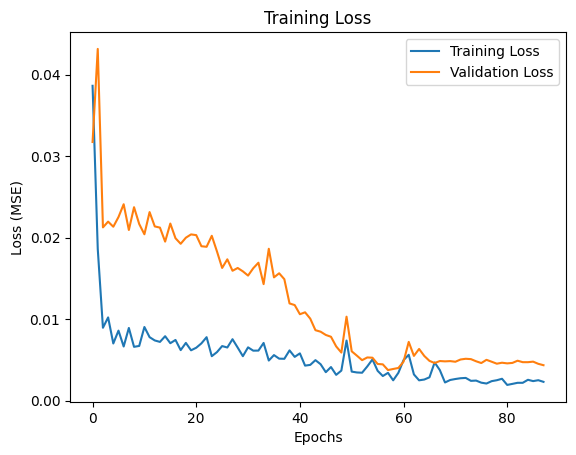

In [8]:
# ================================================================
# TRAINING + CALLBACKS
# ================================================================

# Define path to save the best model during training
checkpoint_path = os.path.join(MODEL_DIR, 'best_model.keras')

# Define callbacks for training
callbacks = [
    # EarlyStopping: stops training if validation loss doesn't improve for 30 epochs
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),

    # ReduceLROnPlateau: reduces learning rate by factor of 0.5 if validation loss plateaus for 10 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),

    # ModelCheckpoint: saves the best model based on validation loss
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

# Train the model on the training data with validation on the test set
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=8,
    callbacks=callbacks,
    verbose=2
)

# Plot training and validation loss curves to visualize convergence
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# **Evaluation of LSTM Model**


- **Purpose**: Assess the performance of the trained LSTM model on unseen test data.
- **Steps**:
  1. **Predict**:
      - Use `model.predict(X_test)` to generate predictions on the test set.
  2. **Inverse scaling**:
      - Transform predictions and true values back to original passenger counts using the fitted `scaler`.
  3. **Metrics calculation**:
      - `RMSE`: Root Mean Squared Error for overall prediction error magnitude.
      - `MAE`: Mean Absolute Error for average absolute deviation.
      - `MAPE`: Mean Absolute Percentage Error for relative error in percentage.
  4. **Print metrics**:
      - Display RMSE, MAE, and MAPE to quantify accuracy.
  5. **Plotting**:
      - Compare actual vs predicted passenger counts over the test period.
      - Visualize prediction quality and alignment with true data.
- **Verification**:
  - Metrics provide numerical assessment; plot confirms model's predictive behavior.
- **Why important?**
  1. Evaluate model reliability and accuracy on unseen data.
  2. Identify under/over-prediction patterns.
  3. Essential step before deploying the model for forecasting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
RMSE: 31.736836745974305
MAE: 28.13933563232422
MAPE: 6.5167174


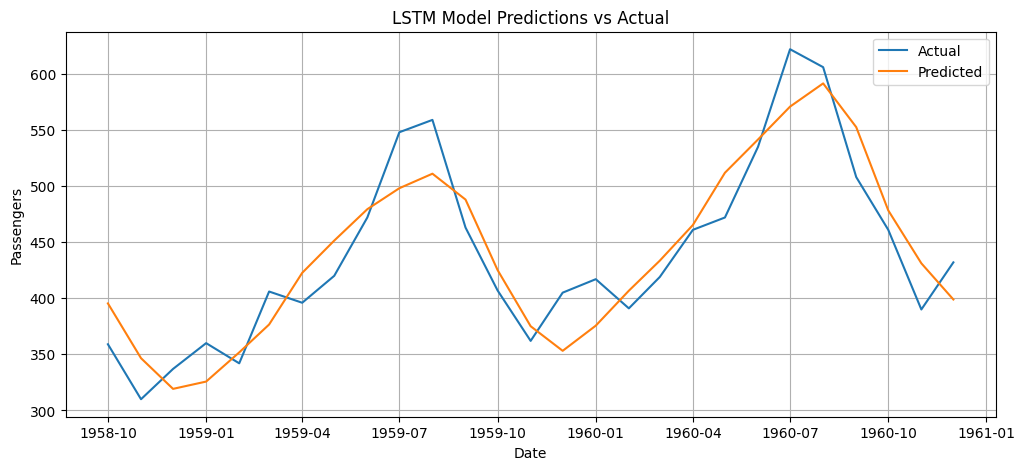

In [9]:
# ================================================================
# EVALUATION
# ================================================================

# Predict on test data
pred_scaled = model.predict(X_test)

# Inverse transform scaled predictions and true values to original scale
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(true, pred))  # Root Mean Squared Error
mae = mean_absolute_error(true, pred)            # Mean Absolute Error
mape = np.mean(np.abs((true - pred) / true)) * 100  # Mean Absolute Percentage Error

# Print evaluation metrics
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

# Plot actual vs predicted passenger counts
test_dates = ts.index[SEQ_LEN + train_size : SEQ_LEN + train_size + len(pred)]
plt.figure(figsize=(12,5))
plt.plot(test_dates, true, label="Actual")
plt.plot(test_dates, pred, label="Predicted")
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(); plt.grid(True)
plt.show()

# **Walk-Forward Forecasting (Fixed)**


- **Purpose**: Generate sequential predictions where each forecast uses previous predictions, simulating real-world deployment.
- **Steps**:
  1. **Initialize history**:
      - Start with training data plus the initial sequence length.
  2. **Iterative prediction**:
      - For each step in the test set:
      - Take the last `SEQ_LEN` values to form the input sequence.
      - Predict the next passenger count.
      - Append the prediction to the history for use in subsequent steps.
      - Save the prediction for evaluation.
  3. **Inverse scaling**:
      - Convert predictions back to original scale using the fitted scaler.
  4. **Plotting**:
      - Compare actual vs walk-forward predictions visually.
- **Verification**:
  - Ensure predictions align reasonably with actual test values.
- **Why important?**
  1. Reflects a realistic forecasting scenario where future values are unknown.
  2. Each step prediction depends on previous forecasts, showing how errors can propagate.
  3. Useful for assessing sequential prediction performance.

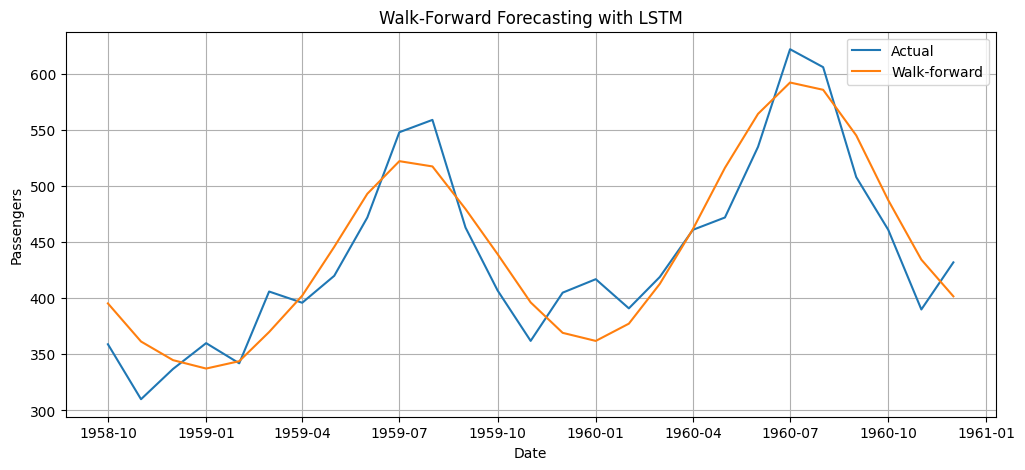

In [10]:
# ================================================================
# WALK-FORWARD FORECASTING (FIXED)
# ================================================================

# Initialize history with training data + sequence length
history_scaled = scaled[:train_size + SEQ_LEN].reshape(-1, 1).tolist()
preds_walk = []

# Perform walk-forward forecasting
for _ in range(len(X_test)):
    # Take the last SEQ_LEN values to form input sequence
    seq = np.array(history_scaled[-SEQ_LEN:]).reshape(1, SEQ_LEN, 1)

    # Predict next value
    yhat = model.predict(seq, verbose=0)

    # Append the predicted scalar to history for the next step
    history_scaled.append([yhat[0][0]])

    # Save prediction for later evaluation
    preds_walk.append(yhat[0][0])

# Inverse transform predictions to original scale
wf_pred = scaler.inverse_transform(np.array(preds_walk).reshape(-1,1))

# Plot actual vs walk-forward predictions
plt.figure(figsize=(12,5))
plt.plot(test_dates, true, label="Actual")
plt.plot(test_dates, wf_pred, label="Walk-forward")
plt.title('Walk-Forward Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(); plt.grid(True)
plt.show()

# **Multi-Step Forecasting (12 Months)**


- **Purpose**: Predict multiple future time steps (12 months) iteratively using the trained LSTM model.
- **Steps**:
  1. **Define forecast horizon**:
      - `HORIZON = 12` months.
  2. **Prepare input sequence**:
      - Use the last `SEQ_LEN` scaled observations from the dataset.
  3. **Iterative prediction**:
      - Copy the input sequence.
      - For each step in the forecast horizon:
      - Predict the next value.
      - Append prediction to the forecast list.
      - Update input sequence by rolling left and inserting the new prediction at the end.
  4. **Inverse scaling**:
      - Convert the forecast back to original passenger counts.
  5. **Generate future dates**:
      - Create a datetime index for the 12 months following the last historical date.
  6. **Plotting**:
      - Compare historical data and multi-step forecast to visualize projections.
- **Verification**:
  - Check forecast values and alignment with historical trends.
- **Why important?**
  1. Provides realistic future projections beyond the test set.
  2. Iterative approach reflects dependency of future predictions on previous forecasts.
  3. Useful for planning and decision-making based on predicted trends.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipython-input-1265061269.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current[0, -1, 0] = yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


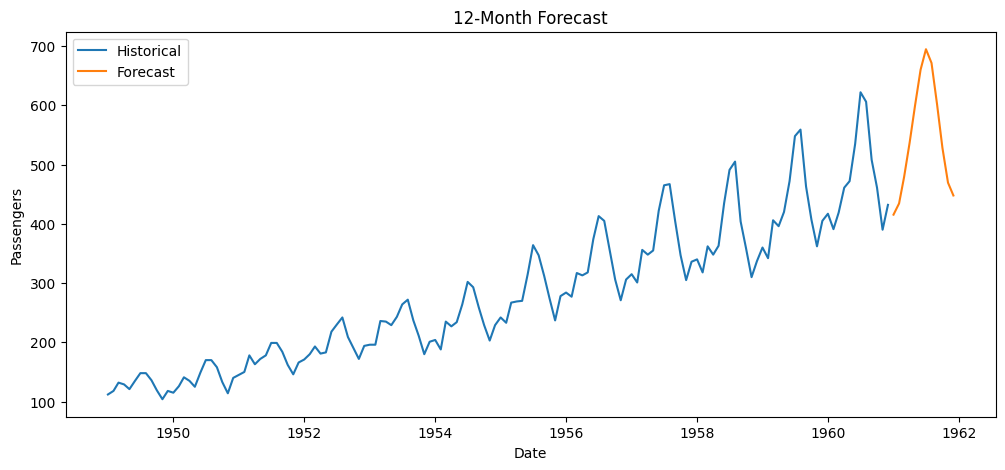

In [11]:
# ================================================================
# MULTI-STEP FORECASTING (12 MONTHS)
# ================================================================

# Define forecast horizon (number of months to predict)
HORIZON = 12

# Take the last SEQ_LEN observations as input for multi-step forecast
input_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
forecast_scaled = []

# Copy input sequence for iterative prediction
current = input_seq.copy()
for _ in range(HORIZON):
    # Predict next value
    yhat = model.predict(current)
    forecast_scaled.append(yhat)

    # Update input sequence: shift left and append the new prediction
    current = np.roll(current, -1, axis=1)
    current[0, -1, 0] = yhat

# Inverse transform predictions to original scale
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1))

# Generate future dates corresponding to the forecast horizon
future_dates = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1), periods=HORIZON, freq='MS')

# Plot historical data and multi-step forecast
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts['passengers'], label='Historical')
plt.plot(future_dates, forecast, label='Forecast')
plt.title("12-Month Forecast")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# **Save Model & Scaler**


- **Purpose**: Persist the trained LSTM model and scaler for future predictions or deployment.
- **Steps**:
  1. **Save model**:
      - Use `model.save()` with the `.keras` format to save the trained LSTM.
  2. **Save scaler**:
      - Use `joblib.dump()` to save the fitted `MinMaxScaler`.
      - Ensures consistent scaling of new data when making predictions.
  3. **Confirmation**:
      - Print a message to confirm successful saving.
- **Why important?**
  1. Avoid retraining the model every time predictions are needed.
  2. Maintain consistency in data preprocessing for future forecasts.
  3. Essential for deployment and reproducibility.

In [12]:
# ================================================================
# SAVE MODEL & SCALER
# ================================================================

# Save the trained LSTM model to the model directory
# Using the '.keras' format for TensorFlow/Keras models
model.save(os.path.join(MODEL_DIR, 'final_lstm.keras'))

# Save the fitted scaler for future use to transform new data consistently
import joblib
joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.save'))

# Confirmation message
print("✅ Model and scaler saved successfully.")

✅ Model and scaler saved successfully.
